In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

# *ktrain*: A Simple Library to Help Train Neural Networks in Keras



*ktrain* is a lightweight wrapper for Keras to help build, train, and deploy neural models in a way that requires a minimal amount of code and a reduced cognitive load. By facilitating the loading and preprocessing of data, tuning learning rates, fitting models with different learning rate policies, inspecting misclassifications, and making predictions on new raw data, *ktrain* allows you to focus more on architecting a good Keras model for your problem.  Inspired by the *fastai* library, it supports:
- a **learning rate finder** to help find a good initial learning rate for your model
- a variety of demonstrably effective **learning rate schedules** to improve performance including SGDR and Leslie Smith's 1cycle and triangular learning rate policies.
-  fast and easy-to-use **pre-canned models** for both text classification (e.g., NBSVM, fastText) and image classification (e.g., ResNet, Wide ResNet, Inception)
-  methods to help you **easily load and preprocess text and image data** from a variety of formats
- easily inspecting data points that were misclassified to help improve your model
- a simple prediction API for **saving and deploying models and data-preprocessing steps** to easily make predictions on new raw data

We will begin by importing the *ktrain* module.  The *ktrain* library contains sub-modules to handle specific types of data. Currently, we have the *ktrain.vision* module for image classification and the *ktrain.text* module for text classification. Additional sub-modules will be added over time for tackling various other types of problems.  We will import the *vision* module here, as this tutorial example involves image classification.

In [2]:
import ktrain
from ktrain import vision as vis

Using TensorFlow backend.


## Loading Data:  An Obligatory MNIST Example

*ktrain* has convenience functions to help you easily load data from a variety of formats (e.g., training data in folders or CSVs). Examples include:

`ktrain.vision` module:
- `images_from_folder`:  labels are represented as subfolders containing images [ [example notebook] ](https://github.com/amaiya/ktrain/blob/master/examples/vision/dogs_vs_cats-ResNet50.ipynb)
- `images_from_csv`: labels are mapped to images in a CSV file [ [example notebook](https://github.com/amaiya/ktrain/blob/master/examples/vision/planet-ResNet50.ipynb) ]
- `images_from_fname`: labels are included as part of the filename and must be extracted using a regular expression [ [example notebook](https://github.com/amaiya/ktrain/blob/master/examples/vision/pets-ResNet50.ipynb) ]
- `images_from_array`: images and labels are stored in array [ [example notebook](https://github.com/amaiya/ktrain/blob/master/examples/vision/mnist-images_from_array_example.ipynb) ]

`ktrain.text` module:
- `texts_from_folder`:  labels are represented as subfolders containing text files [ [example notebook] ](https://github.com/amaiya/ktrain/blob/master/examples/text/IMDb-BERT.ipynb)
- `texts_from_csv`: texts and associated labels are stored in columns in a CSV file [ [example notebook](https://github.com/amaiya/ktrain/blob/master/examples/text/toxic_comments-fasttext.ipynb) ]
- `texts_from_df`: texts and associated labels are stored in columns in a *pandas* DataFrame [ [example notebook](https://github.com/amaiya/ktrain/blob/master/examples/text/ArabicHotelReviews-nbsvm.ipynb) ]
- `texts_from_array`: texts and labels are loaded and preprocessed from an array [ [example notebook](https://github.com/amaiya/ktrain/blob/master/examples/text/20newsgroup-distilbert.ipynb) ]

`ktrain.tabular` module:
- `tabular_from_csv`: dependent and independent variables are stored as columns in a CSV file [ [example notebook](https://github.com/amaiya/ktrain/blob/master/examples/tabular/tabular_classification_and_regression_example.ipynb) ]
- `tabular_from_df`: dependent and independent variables are stored as columns in a *pandas* DataFrame [ [example notebook](https://github.com/amaiya/ktrain/blob/develop/examples/tabular/tabular_classification_and_regression_example.ipynb) ]


We will load the MNIST image classification dataset here, since no neural network tutorial is complete without an obligatory [MNIST](http://en.wikipedia.org/wiki/MNIST_database) example.  

First, download a PNG version of the **MNIST** dataset from [here](https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz) and set DATADIR to the extracted folder.

Next, use the ```images_from_folder``` function to load the data as a generator (i.e., Keras DirectoryIterator object).  This function assumes the following directory structure:
```
  ├── datadir
    │   ├── train
    │   │   ├── class0       # folder containing documents of class 0
    │   │   ├── class1       # folder containing documents of class 1
    │   │   ├── class2       # folder containing documents of class 2
    │   │   └── classN       # folder containing documents of class N
    │   └── test 
    │       ├── class0       # folder containing documents of class 0
    │       ├── class1       # folder containing documents of class 1
    │       ├── class2       # folder containing documents of class 2
    │       └── classN       # folder containing documents of class N
```
The *train_test_names* argument can be used, if the train and test subfolders are named differently (e.g., *test* folder is called *valid*).  The **data_aug** parameter can be used to employ [data augmentation](https://arxiv.org/abs/1712.04621). We set this parameter using the ```get_data_aug``` function, which is a simple wrapper around Keras ImageDataGenerator and returns a data augmentation scheme with the following defaults:
```
# default data augmentation in ktrain
def get_data_aug(rotation_range=40,
                 zoom_range=0.2,
                 width_shift_range=0.2,
                 height_shift_range=0.2,
                 horizontal_flip=False,
                 vertical_flip=False,
                 **kwargs):

```
Additional arguments can be supplied to further configure data augmentation.  See [Keras documentation](https://keras.io/preprocessing/image/#imagedatagenerator-class) for a full set of augmentation parameters.  Since the defaults are designed for "normal-sized" photos and may be too aggressive for little 28x28 MNIST images, we have reduced some of the values slightly. We have also set the image size to 28x28 and the color mode to grayscale.  If using alternative values for these parameters, the image will automatically be adjusted (e.g., resized, converted from 1-channel to 3-channel image).  This is necessary, for instance, if a particular model only supports 3-channel images ('rgb' color_mode) or a minimum image size (e.g., 32x32). The defaults are ```target_size=(224,224)``` and ```color_mode='rgb'```, which tend to work well for most other image classification problems.

In [3]:
DATADIR = 'data/mnist_png'
data_aug = vis.get_data_aug(  rotation_range=15,
                              zoom_range=0.1,
                              width_shift_range=0.1,
                              height_shift_range=0.1)
(train_data, val_data, preproc) = vis.images_from_folder(
                                              datadir=DATADIR,
                                              data_aug = data_aug,
                                              train_test_names=['training', 'testing'], 
                                              target_size=(28,28), color_mode='grayscale')

Found 60000 images belonging to 10 classes.
Found 60000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


(The training folder is scanned twice - once to inspect the data for normalization and a second time to return a DirectoryIterator generator).  

All *ktrain* data-loading functions return a Preprocessor instance (stored in the variable *preproc* above).  Preprocessor instances are used to automaticlaly preprocess and appropriately normalize raw data when making predictions on new examples.  This is demonstrated a little later.

## Defining a Model

Having loaded the data, we now have to define a model.  You can either define your own model or, if appropriate, can use a pre-canned model included in *ktrain*.  The list of available image classification models can be viewed using the ```print_image_classifiers``` function.

In [4]:
vis.print_image_classifiers()

pretrained_resnet50: 50-layer Residual Network (pretrained on ImageNet)
resnet50: 50-layer Resididual Network (randomly initialized)
pretrained_mobilenet: MobileNet Neural Network (pretrained on ImageNet - TF only)
mobilenet: MobileNet Neural Network (randomly initialized - TF only)
pretrained_inception: Inception Version 3  (pretrained on ImageNet)
inception: Inception Version 3 (randomly initialized)
wrn22: 22-layer Wide Residual Network (randomly initialized)
default_cnn: a default Convolutional Neural Network


If opting to use a pre-canned model, the model can be loaded using the ```image_classifier``` function.
For the MNIST problem, we will use the 'default_cnn' model, which is a simple CNN with the structure shown below. Note that the ```image_classifier``` function accepts the training data as an argument, as the data will be inspected so that the model can be automatically configured correctly for your problem (e.g., model will be configured for multilabel classification if classes are not mutually exclusive).

In [5]:
model = vis.image_classifier('default_cnn', train_data, val_data)

Is Multi-Label? False
default_cnn model created.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

## Wrapping Your Data and Model in a Learner Object

Armed with some data and a model, you would normally call the ```fit``` method of the model instance when using Keras.  With *ktrain*, we will instead first wrap the model and data in a Learner object using the ```get_learner``` function.  The Learner object will help us train our model in various ways.

In [7]:
learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, 
                             workers=8, use_multiprocessing=True, batch_size=64)

Additional arguments for ```get_learner``` include *batch_size*, *workers*, and *use_multiprocessing*.  The *workers* and *use_multiprocessing* arguments only take effect if train_data is a generator, and they each map directly to the *workers* and *use_multiprocessing* arguments to ```model.fit_generator``` in Keras. These values can be adjusted based on your system and data.  Here, we will use eight workers and a larger batch size since the MNIST images are quite small.


## Learning Rate Finder

The Learner object can be used to find a good learning rate for your model using the ```lr_find``` and ```lr_plot``` methods.  The ```lr_find``` method simulates training at different learning rates and tracks the loss.  After visually inspecting the plot generated by ```lr_plot```, we choose the highest learning rate still associated with a falling loss. We will choose a rate that is aggressively high: **0.001** (or 1e-3) for use in training.  (The learning rate of 0.001 happens to be the default learning rate for the Adam optimizer in Keras.  The default is a good fit for this particular instance, but this is most definitely not always the case.) 

In [8]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
937/937 [==============================] - 16s 17ms/step - loss: 3.2559 - acc: 0.0982
Epoch 2/5
937/937 [==============================] - 15s 16ms/step - loss: 2.0976 - acc: 0.3472
Epoch 3/5
937/937 [==============================] - 15s 16ms/step - loss: 0.3393 - acc: 0.8939
Epoch 4/5
780/937 [=======================>......] - ETA: 2s - loss: 0.3107 - acc: 0.9132

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


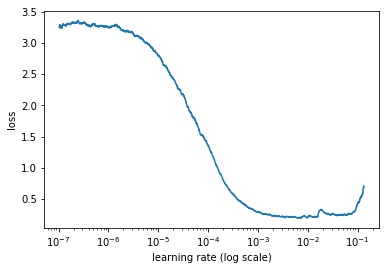

In [9]:
learner.lr_plot()

The **n_skip_beginning** and **n_skip_end** arguments to ```lr_plot``` can be used to zoom into the plot, but we have not used it here.  Using the plot, we select the maximal learning rate associated with a still falling loss. In this case, we will choose 1e-3, which happens to be the default learning rate for the Adam optimizer.  This will not always be the case.

## Training with Learning Rate Schedules

Varying the learning rate cyclically during training has been shown to be [effective](https://arxiv.org/abs/1506.01186) and a good general practice.  *ktrain* allows you to easily employ a variety of demonstrably effective learning rate policies during training. These include:

* a [triangular learning rate policy](https://arxiv.org/abs/1506.01186) available via the ```autofit``` method
* a [1cycle policy](https://arxiv.org/abs/1803.09820) available via the ```fit_onecycle``` method
* an [SGDR](https://arxiv.org/abs/1608.03983) (Stochastic Gradient Descent with Restart) schedule available using the ```fit``` method by supplying a *cycle_len* argument.

The ```autofit``` and ```fit_onecycle``` methods tend to be good choices that produce pleasing results.  For more information on learning rate schedules, see the [*ktrain* tutorial notebook on tuning learning rates](https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-02-tuning-learning-rates.ipynb).

The ```autofit``` method in *ktrain* employs a triangular learning rate schedule and uses the supplied learning rate as the maximum learning rate.  The ```autofit``` method accepts two primary arguments. The first (required) is the learning rate (**lr**) to be used, which can be found using the learning rate finder above. The second is optional and indicates the number of epochs (**epochs**) to train.  If **epochs** is not supplied as a second argument, then ```autofit``` will train until the validation loss no longer improves after a certain period. This period can be configured using the **early_stopping** argument.  The ```autofit``` method will also reduce the learning rate when validation loss no longer improves, which can be configured using the reduce_on_plateau argument to ```autofit```.  At the end of training, the weights producing the lowest validation loss are automatically loaded into the model.


The ```autofit``` method also accepts a **checkpoint_folder** argument representing the path to a directory. If supplied, the weights of the model after each epoch will be saved to this folder.  Thus, the model state of any epoch can be easily restored using the ```learner.model.load_weights``` method, if the final validation accuracy is not desired. In this case, the final accuracy is quite satisfactory for this model.  

As shown below, this learning rate scheme achieves an accuracy of **99.64%** after 10 epochs despite the simplicity of our model. 


In [8]:
learner.autofit(0.001, 10)



begin training using triangular learning rate policy with max lr of 0.001...
Epoch 1/10
937/937 [==============================] - 17s 18ms/step - loss: 0.5395 - acc: 0.8311 - val_loss: 0.0342 - val_acc: 0.9882
Epoch 2/10
937/937 [==============================] - 15s 16ms/step - loss: 0.1266 - acc: 0.9612 - val_loss: 0.0243 - val_acc: 0.9924
Epoch 3/10
937/937 [==============================] - 15s 16ms/step - loss: 0.0924 - acc: 0.9715 - val_loss: 0.0213 - val_acc: 0.9936
Epoch 4/10
937/937 [==============================] - 15s 16ms/step - loss: 0.0769 - acc: 0.9769 - val_loss: 0.0171 - val_acc: 0.9942
Epoch 5/10
937/937 [==============================] - 15s 16ms/step - loss: 0.0686 - acc: 0.9791 - val_loss: 0.0160 - val_acc: 0.9950
Epoch 6/10
937/937 [==============================] - 15s 16ms/step - loss: 0.0632 - acc: 0.9810 - val_loss: 0.0137 - val_acc: 0.9952
Epoch 7/10
937/937 [==============================] - 15s 16ms/step - loss: 0.0535 - acc: 0.9830 - val_loss: 0.0128 -

Now, we will demonstrate training using the ```fit_onecycle``` method, where similar results are achieved after 10  epochs.

In [26]:
learner.reset_weights(verbose=0)
learner.fit_onecycle(0.001, 10)



begin training using onecycle policy with max lr of 0.001...
Epoch 1/10
937/937 [==============================] - 16s 17ms/step - loss: 0.7958 - acc: 0.7482 - val_loss: 0.0804 - val_acc: 0.9739
Epoch 2/10
937/937 [==============================] - 16s 17ms/step - loss: 0.1713 - acc: 0.9479 - val_loss: 0.0363 - val_acc: 0.9876
Epoch 3/10
937/937 [==============================] - 16s 17ms/step - loss: 0.1110 - acc: 0.9664 - val_loss: 0.0327 - val_acc: 0.9893
Epoch 4/10
937/937 [==============================] - 15s 16ms/step - loss: 0.0889 - acc: 0.9726 - val_loss: 0.0228 - val_acc: 0.9919
Epoch 5/10
937/937 [==============================] - 15s 16ms/step - loss: 0.0750 - acc: 0.9772 - val_loss: 0.0289 - val_acc: 0.9915
Epoch 6/10
937/937 [==============================] - 16s 17ms/step - loss: 0.0668 - acc: 0.9790 - val_loss: 0.0232 - val_acc: 0.9925
Epoch 7/10
937/937 [==============================] - 15s 16ms/step - loss: 0.0535 - acc: 0.9842 - val_loss: 0.0159 - val_acc: 0.9941

Finally, we invoke ```autofit``` **without** supplying the number of epochs. As mentioned, the training will automatically stop when the validation loss fails to improve. Moreover, the maximum learning rate will automatically decrease periodically. We supply the *checkpoint_folder* argument to ensure we can restore the weights from any epoch after training completes.

In [12]:
learner.reset_weights(verbose=0)
learner.autofit(0.001, checkpoint_folder='/tmp/mnist')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Epoch 1/1024
937/937 [==============================] - 15s 16ms/step - loss: 0.3721 - acc: 0.8839 - val_loss: 0.0337 - val_acc: 0.9892
Epoch 2/1024
937/937 [==============================] - 15s 16ms/step - loss: 0.1040 - acc: 0.9680 - val_loss: 0.0230 - val_acc: 0.9928
Epoch 3/1024
937/937 [==============================] - 15s 16ms/step - loss: 0.0791 - acc: 0.9764 - val_loss: 0.0200 - val_acc: 0.9942
Epoch 4/1024
937/937 [==============================] - 15s 16ms/step - loss: 0.0689 - acc: 0.9790 - val_loss: 0.0169 - val_acc: 0.9947
Epoch 5/1024
937/937 [==============================] - 15s 16ms/step - loss: 0.0608 - acc: 0.9820 - val_loss: 0.0153 - val_acc: 0.9948
Epoch 6/1024
937/937 [==============================] - 16s 17ms/step - loss: 0.0550 - acc: 0.9832 - val_loss: 0.0160 - val_acc: 0.9952


After training completes, weights producing the lowest validation loss are loaded into the model:

In [16]:
loss, acc = learner.model.evaluate_generator(val_data, steps=len(val_data))
print('final loss:%s, final score:%s' % (loss, acc))

final loss:0.011306069766094152, final score:0.9964


In this case, the loweset validation loss produces the highest accuracy (**99.64%**).  If this is not the case, then weights producing the highest accuracy can be re-loaded into the model from the checkpoint folder:

```
# loading weights from the end of 18th epoch
learner.model.load_weights('weights-18.hdf5')
```

Note that, in the demonstrations above, the ```fit_onecycle```,and ```autofit``` methods produced similar validation accuracies in a similar number of epochs.  This may not always be the case. 

## Inspecting Misclassifications

With a trained model in hand, let's view the top 3 most misclassified examples in our validation set. This can be done using the ```learner.view_top_losses``` method, which displays the validation examples with the highest loss.

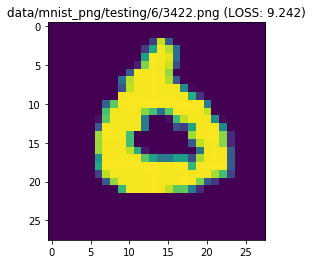

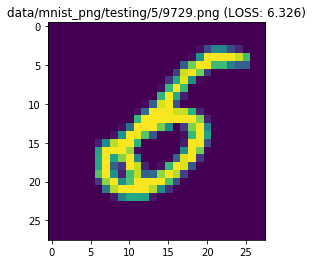

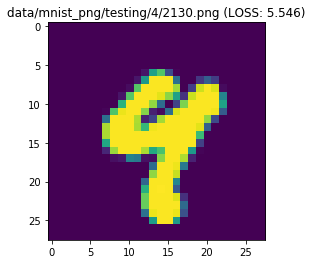

In [19]:
learner.view_top_losses(n=3, preproc=preproc)

As can be seen, such images are legitmately challenging to classify - even for humans. In some cases, inspecting misclassifications can help shed light on how to improve your model or improve data preprocessing strategies.

## Predicting New Examples

Recall that our call to ```images_from_folder``` returned a Preprocessor instance as a third return value. We can take our model and the Preprocessor instance and wrap them in a Predictor object to easily make predictions on new raw data.

In [11]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [12]:
predictor.get_classes()

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [13]:
predictor.predict_filename(DATADIR+'/testing/7/7021.png')

['7']

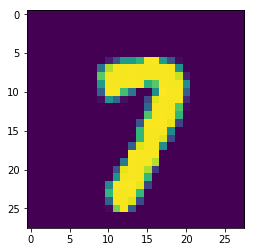

In [14]:
vis.show_image(DATADIR+'/testing/7/7021.png')

The predictor object can be saved and reloaded later for use within a deployed application.

In [15]:
predictor.save('/tmp/mymnist')

In [16]:
predictor = ktrain.load_predictor('/tmp/mymnist')

In [17]:
# let's make predictions for all images depicting 3 in our validation set
predictor.predict_folder(DATADIR+'/testing/3/')[:10]

Found 1010 images belonging to 1 classes.


[('3/1020.png', '3'),
 ('3/1028.png', '3'),
 ('3/1042.png', '3'),
 ('3/1062.png', '3'),
 ('3/1066.png', '3'),
 ('3/1067.png', '3'),
 ('3/1069.png', '3'),
 ('3/1072.png', '3'),
 ('3/1092.png', '3'),
 ('3/1095.png', '3')]

## Using *ktrain* with Your Own Custom Keras Models


In the examples above, we employed the use of a pre-canned model that we loaded using the ```image_classifier``` function.  This is not required, as *ktrain* is designed to work seamlessly with Keras.

For instance, in the example below, we use *ktrain* with a custom model that we define ourselves.   The code below was copied directly from the [Keras MNIST example](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).

In [18]:
#import some necessary modules
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

# load data as you normally would in Keras
NUM_CLASSES = 10


# define a model as you normally would in Keras
def load_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer='adam',
                   metrics=['accuracy'])
    return model

# load the data and the model    
if K.image_data_format() == 'channels_first':
    input_shape=(1,28,28)
else:
    input_shape=(28,28,1)

model = load_model(input_shape)

Using this custom model, we can follow the exact same training procedure as above and take advantage of various *ktrain* features.

In [25]:
# wrap model and data in Learner instance
learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, 
                             workers=8, use_multiprocessing=True, batch_size=64)

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
937/937 [==============================] - 12s 12ms/step - loss: 2.3264 - acc: 0.1166
Epoch 2/5
937/937 [==============================] - 12s 13ms/step - loss: 1.5400 - acc: 0.4883
Epoch 3/5
937/937 [==============================] - 12s 12ms/step - loss: 0.3973 - acc: 0.8754
Epoch 4/5
469/937 [==============>...............] - ETA: 6s - loss: 0.6880 - acc: 0.7913

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


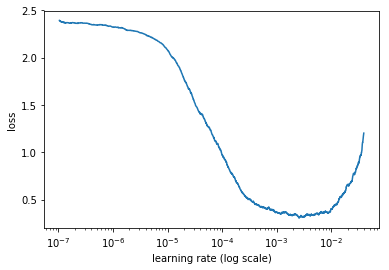

In [26]:
# find a good learning rate
learner.lr_find()
learner.lr_plot()

In [28]:
# train using a triangular learning rate policy
learner.autofit(0.001, 3)



begin training using triangular learning rate policy with max lr of 0.001...
Epoch 1/3
937/937 [==============================] - 12s 13ms/step - loss: 0.1412 - acc: 0.9585 - val_loss: 0.0253 - val_acc: 0.9914
Epoch 2/3
937/937 [==============================] - 12s 13ms/step - loss: 0.1272 - acc: 0.9620 - val_loss: 0.0247 - val_acc: 0.9916
Epoch 3/3
937/937 [==============================] - 12s 13ms/step - loss: 0.1172 - acc: 0.9644 - val_loss: 0.0226 - val_acc: 0.9921


In [29]:
# get a Predictor instance
predictor = ktrain.get_predictor(learner.model, preproc)

In [41]:
# make predictions on new data
predictor.predict_folder(DATADIR+'/testing/2')[:10]

Found 1032 images belonging to 1 classes.


[('2/1.png', '2'),
 ('2/1002.png', '2'),
 ('2/1016.png', '2'),
 ('2/1031.png', '2'),
 ('2/1036.png', '2'),
 ('2/1049.png', '2'),
 ('2/1050.png', '2'),
 ('2/1053.png', '2'),
 ('2/1056.png', '2'),
 ('2/106.png', '2')]